<a href="https://colab.research.google.com/github/sakshamkumar1/tensorflow-notebooks/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-041f34fa-add2-99e8-4ed1-c1318634df81)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-05-16 16:18:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-16 16:18:47 (64.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data("nlp_getting_started.zip")

--2023-05-16 16:18:51--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.128, 74.125.31.128, 142.250.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-05-16 16:18:51 (113 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
len(train_df), len(test_df)

(7613, 3263)

In [9]:
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
Drunk Meals 101: What To Cook When You're Totally Obliterated http://t.co/m19iVWrdkk

---

Target: 0 (not real disaster)
Text:
U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/x2Wn7O2a3w via @Change

---

Target: 1 (real disaster)
Text:
#Australia #News ; #Japan marks 70th anniversary of #Hiroshima atomic bombing  http://t.co/7aD0L7cgee READ MORE; http://t.co/hHzQl9tzNP

---

Target: 1 (real disaster)
Text:
Came across this fire video not mine..enjoy..#fire #firemen #firetruck #emergency #rescue #911 #summertime #sirensÛ_ http://t.co/hcYAJsAcfJ

---

Target: 0 (not real disaster)
Text:
New post: 'People are finally panicking about cable TV' http://t.co/pkfV8lkSlD

---



### Split data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_df.iloc[:2].to_numpy()

array([[1, nan, nan,
        'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
        1],
       [4, nan, nan, 'Forest fire near La Ronge Sask. Canada', 1]],
      dtype=object)

In [12]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [13]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

### Text vectorization (tokenization)

In [15]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=None,
                                    pad_to_max_tokens=False)

In [17]:
len(train_sentences[0].split())

7

In [18]:
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [19]:
text_vectorizer.adapt(train_sentences)

In [20]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 @gg_keeponrockin @StrawberrySoryu Oh okay I just got the message twice and got suspicious. Sorry.  I'll check it out!        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1, 8034,  392,  734,    8,   29,  100,    2, 2049, 1936,    7,
         100, 7890,  875,  421]])>

In [22]:
text_vectorizer(random_sentence)

<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([   1, 8034,  392,  734,    8,   29,  100,    2, 2049, 1936,    7,
        100, 7890,  875,  421])>

In [23]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Most common words in vocab: {top_5_words}")
print(f"Least common words in vocab:{bottom_5_words}")

Most common words in vocab: ['', '[UNK]', 'the', 'a', 'in']
Least common words in vocab:['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [24]:
len(words_in_vocab)

10000

### Creating an Embedding using an Embedding Layer

In [25]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length)
embedding

In [26]:
random_sentence = random.choice(train_sentences)
print(f"Original test:\n{random_sentence}\
        \n\nEmbedded version:")

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original test:
@mattcohen4fake Gamma Ray January Worlds Collide She Waits Be Me Wave Past Perfect Reunion Lucky Cool If I Come Over Hot Times...        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04599265,  0.0465833 ,  0.04065571, ...,  0.04016523,
         -0.04529741,  0.02829615],
        [-0.04599265,  0.0465833 ,  0.04065571, ...,  0.04016523,
         -0.04529741,  0.02829615],
        [-0.01970588, -0.03099442, -0.04715281, ...,  0.01266373,
         -0.00423541,  0.00659199],
        ...,
        [-0.03276543, -0.0232388 , -0.02442447, ...,  0.01460829,
         -0.04519098,  0.04932458],
        [-0.03645694,  0.04296422,  0.02568135, ...,  0.00596539,
          0.00459452, -0.04246717],
        [-0.02902912, -0.03137151, -0.02948232, ...,  0.03178464,
          0.02437497, -0.03174585]]], dtype=float32)>

In [27]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.04599265,  0.0465833 ,  0.04065571,  0.01213862,  0.03610076,
        0.02602379, -0.01082284,  0.02541436,  0.0244011 , -0.01408378,
       -0.02927009, -0.03609034, -0.03770486, -0.04357513, -0.02237218,
       -0.03683846, -0.04664216, -0.00248543, -0.02127733, -0.01193515,
        0.03833089, -0.01863616, -0.03890198, -0.03733944, -0.02300391,
        0.04775032,  0.00940949,  0.03112343,  0.00213331,  0.00585495,
        0.00842116, -0.03264838,  0.02667687,  0.01995057,  0.00752927,
       -0.01810209, -0.02671764,  0.0427683 ,  0.0317972 ,  0.02705213,
       -0.0290465 ,  0.00337231, -0.03785616,  0.04604423,  0.04214528,
        0.00968074,  0.02065085,  0.01939889, -0.03544413, -0.04879112,
        0.01717976, -0.04392783, -0.01985619, -0.01187795, -0.04774653,
       -0.04229072, -0.01486957,  0.00093959,  0.03314951, -0.02728826,
       -0.00734637, -0.03129437, -0.01834874,  0.03673482, -0.01686541,
       -0.027420

### Model 0: Getting a Baseline

In [28]:
# from sklearn.naive_bayes import GaussianNB

# gnb = GaussianNB()
# gnb.fit(train_sentences, train_labels)
# gnb.score(val_sentences, val_labels)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [31]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

## Creating an evaluation function for our model experiments

In [32]:
# Function to evaluate: accuracy, precision, recall, F1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [33]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 1: A simple dense model (feed forward neural network)

In [34]:
from helper_functions import create_tensorboard_callback

SAVE_DIR = "model_logs"

In [35]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [36]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [37]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1 = model_1.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                               experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20230516-161857
Epoch 1/5
215/215 [==============================] - 35s 137ms/step - loss: 0.6111 - accuracy: 0.6955 - val_loss: 0.5393 - val_accuracy: 0.7388
Epoch 2/5
215/215 [==============================] - 7s 33ms/step - loss: 0.4403 - accuracy: 0.8206 - val_loss: 0.4732 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3463 - accuracy: 0.8621 - val_loss: 0.4587 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 6s 26ms/step - loss: 0.2835 - accuracy: 0.8901 - val_loss: 0.4653 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.2365 - accuracy: 0.9124 - val_loss: 0.4798 - val_accuracy: 0.7835


In [38]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4798 - accuracy: 0.7835


[0.47981753945350647, 0.7834645509719849]

In [39]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[0.36723185],
       [0.79564685],
       [0.99748695],
       [0.1201833 ],
       [0.11691184],
       [0.9387787 ],
       [0.9153642 ],
       [0.9937615 ],
       [0.96607524],
       [0.30103666]], dtype=float32)

In [40]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [41]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [42]:
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.34645669291339,
 'precision': 0.7875988615317319,
 'recall': 0.7834645669291339,
 'f1': 0.7806382038884261}

In [43]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [44]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Model 2: LSTM

In [45]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(f"After embedding: {x.shape}")
x = layers.LSTM(64, activation="tanh", return_sequences=True)(x)
print(f"After LSTM cell: {x.shape}")
x = layers.LSTM(64, activation="tanh")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

After embedding: (None, 15, 128)
After LSTM cell: (None, 15, 64)


In [46]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_2 = model_2.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                               experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230516-162022
Epoch 1/5
215/215 [==============================] - 24s 78ms/step - loss: 0.2172 - accuracy: 0.9215 - val_loss: 0.6824 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 6s 26ms/step - loss: 0.1552 - accuracy: 0.9422 - val_loss: 0.6410 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1313 - accuracy: 0.9502 - val_loss: 0.7083 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.1062 - accuracy: 0.9583 - val_loss: 0.7850 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0850 - accuracy: 0.9670 - val_loss: 0.8709 - val_accuracy: 0.7690


In [47]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


((762, 1),
 array([[1.7605092e-01],
        [6.1144060e-01],
        [9.9983835e-01],
        [1.7473395e-01],
        [2.9205007e-04],
        [9.9875414e-01],
        [9.6679270e-01],
        [9.9986327e-01],
        [9.9977261e-01],
        [4.7743991e-01]], dtype=float32))

In [48]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [49]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.9028871391076,
 'precision': 0.7687139520620504,
 'recall': 0.7690288713910761,
 'f1': 0.7683358548586026}

## Model 3: GRU

In [50]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(f"After embedding: {x.shape}")
x = layers.GRU(64, activation="tanh", return_sequences=True)(x)
print(f"After GRU cell: {x.shape}")
x = layers.GRU(64, activation="tanh")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

After embedding: (None, 15, 128)
After GRU cell: (None, 15, 64)


In [94]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3_history = model_3.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                               experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230516-163128
Epoch 1/5
215/215 [==============================] - 29s 114ms/step - loss: 0.0515 - accuracy: 0.9783 - val_loss: 1.2662 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0387 - accuracy: 0.9820 - val_loss: 1.4080 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0331 - accuracy: 0.9832 - val_loss: 1.6365 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0344 - accuracy: 0.9834 - val_loss: 1.3241 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0429 - accuracy: 0.9791 - val_loss: 1.4539 - val_accuracy: 0.7690


In [95]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10], model_3_pred_probs.shape

24/24 [==============================] - 1s 3ms/step


(array([[2.3487410e-04],
        [8.8181794e-01],
        [9.9967766e-01],
        [7.8338355e-02],
        [9.0341098e-05],
        [9.9937963e-01],
        [9.1364849e-01],
        [9.9967206e-01],
        [9.9958009e-01],
        [8.9204669e-01]], dtype=float32),
 (762, 1))

In [96]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [97]:
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.9028871391076,
 'precision': 0.7708613696015271,
 'recall': 0.7690288713910761,
 'f1': 0.766802361272573}

## Model 4: Bidirectional RNN Model

In [52]:
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(f"After embedding: {x.shape}")
x = layers.Bidirectional(LSTM(64, activation="tanh", return_sequences=True))(x)
print(f"After Bidirectional LSTM cell: {x.shape}")
x = layers.LSTM(64, activation="tanh")(x)
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional_LSTM")

After embedding: (None, 15, 128)
After Bidirectional LSTM cell: (None, 15, 128)
(None, 64)


In [53]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_4 = model_4.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                               experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230516-162203
Epoch 1/5
215/215 [==============================] - 34s 102ms/step - loss: 0.1032 - accuracy: 0.9672 - val_loss: 1.2062 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0510 - accuracy: 0.9783 - val_loss: 1.1333 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0431 - accuracy: 0.9809 - val_loss: 1.3306 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0419 - accuracy: 0.9797 - val_loss: 1.4173 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0383 - accuracy: 0.9815 - val_loss: 1.5299 - val_accuracy: 0.7703


In [54]:
model_4.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 7ms/step - loss: 1.5299 - accuracy: 0.7703


[1.5299221277236938, 0.7703412175178528]

In [55]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10], val_labels[:10]

24/24 [==============================] - 2s 6ms/step


(array([[7.7966577e-04],
        [8.3222407e-01],
        [9.9996257e-01],
        [8.3926566e-02],
        [1.7539570e-04],
        [9.9993682e-01],
        [9.9859768e-01],
        [9.9996662e-01],
        [9.9996400e-01],
        [9.9950767e-01]], dtype=float32),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [56]:
model_4_pred_probs.shape

(762, 1)

In [57]:
val_sentences.shape

(762,)

In [58]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [59]:
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 77.03412073490814,
 'precision': 0.7751330918759862,
 'recall': 0.7703412073490814,
 'f1': 0.7668707484010339}

## Model 5: Conv1D

In [60]:
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d_layer = layers.Conv1D(filters=32,
                              kernel_size=5,
                              activation="relu")
conv_1d_output = conv_1d_layer(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
print(f"Embedding output shape: {embedding_test.shape}")
print(f"Conv1D output shape: {conv_1d_output.shape}")
print(f"Max pool  output shape: {max_pool_output.shape}")

Embedding output shape: (1, 15, 128)
Conv1D output shape: (1, 11, 32)
Max pool  output shape: (1, 32)


In [61]:
print(f"Embedding output: {embedding_test}")
print(f"Conv1D output: {conv_1d_output}")
print(f"Max pool output: {max_pool_output}")

Embedding output: [[[ 0.00475067 -0.02042948  0.00859052 ... -0.03436616  0.01949909
    0.00631697]
  [ 0.0484399  -0.01534857 -0.05398273 ... -0.04800991  0.04555283
    0.06727511]
  [ 0.02595756 -0.00618231  0.0297454  ...  0.04940218  0.01082239
   -0.03275918]
  ...
  [ 0.00460909 -0.02714857  0.00260069 ...  0.00426603  0.02535196
    0.00090868]
  [ 0.00460909 -0.02714857  0.00260069 ...  0.00426603  0.02535196
    0.00090868]
  [ 0.00460909 -0.02714857  0.00260069 ...  0.00426603  0.02535196
    0.00090868]]]
Conv1D output: [[[0.01554956 0.         0.         0.         0.02304353 0.10083245
   0.         0.         0.         0.05142863 0.00169078 0.
   0.03247803 0.         0.         0.06093247 0.06141764 0.08699049
   0.10005226 0.         0.         0.03987079 0.00627773 0.05252609
   0.         0.04638075 0.01457797 0.01788063 0.05539633 0.04245262
   0.01865479 0.        ]
  [0.         0.03282839 0.         0.02548929 0.02596258 0.
   0.08387908 0.         0.13300002 0

In [62]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_conv1d")

model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 output_layer (Dense)        (None, 1)              

In [63]:
BATCH_SIZE = 32

In [64]:
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_model_5 = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              batch_size=BATCH_SIZE,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_5_conv1d")])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20230516-162342
Epoch 1/5
215/215 [==============================] - 18s 69ms/step - loss: 0.1362 - accuracy: 0.9604 - val_loss: 0.8206 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0783 - accuracy: 0.9731 - val_loss: 1.0032 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0619 - accuracy: 0.9758 - val_loss: 1.0795 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0546 - accuracy: 0.9774 - val_loss: 1.1611 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0507 - accuracy: 0.9801 - val_loss: 1.1700 - val_accuracy: 0.7520


In [65]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:5], model_5_pred_probs.shape

24/24 [==============================] - 0s 5ms/step


(array([[7.0187467e-01],
        [9.9029619e-01],
        [9.9998415e-01],
        [7.1650133e-02],
        [6.7122812e-07]], dtype=float32),
 (762, 1))

In [66]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [67]:
model_5_results = calculate_results(y_true=val_labels,
                                  y_pred=model_5_preds)
model_5_results

{'accuracy': 75.19685039370079,
 'precision': 0.7515527438106716,
 'recall': 0.7519685039370079,
 'f1': 0.7516029615774639}

Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [68]:
sample_sentence

"There's a flood in my street!"

In [69]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you can the universal sentence encoder on a sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [70]:
embed_samples[1][:50]

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([ 0.02992675, -0.07772716, -0.01693196,  0.01940702,  0.00121213,
       -0.05806177, -0.07014291,  0.01900715,  0.05421991,  0.05631086,
       -0.04905614, -0.02482397,  0.03954631,  0.08048373,  0.07105058,
       -0.06532166,  0.01291131, -0.05589466, -0.00210038,  0.0367513 ,
        0.00373515,  0.04555811,  0.05498755,  0.04859943, -0.07956812,
        0.07509261, -0.02012387, -0.01468537, -0.01609612,  0.05054296,
        0.04069993,  0.04472742, -0.04459132, -0.00769066, -0.08697075,
       -0.02373411,  0.05550094,  0.06904221, -0.00191017, -0.00593148,
        0.00569244, -0.02402765,  0.0665727 , -0.03563759, -0.00641889,
       -0.00722764, -0.0200778 , -0.0535391 , -0.04398566,  0.00176768],
      dtype=float32)>

In [71]:
embed_samples[0].shape

TensorShape([512])

In [72]:
embed_samples[1].shape

TensorShape([512])

In [73]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [74]:
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_6_USE")

model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [75]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230516-162505
Epoch 1/5
215/215 [==============================] - 12s 29ms/step - loss: 0.5042 - accuracy: 0.7830 - val_loss: 0.4514 - val_accuracy: 0.8084
Epoch 2/5
215/215 [==============================] - 6s 26ms/step - loss: 0.4146 - accuracy: 0.8135 - val_loss: 0.4409 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.4003 - accuracy: 0.8190 - val_loss: 0.4360 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 5s 24ms/step - loss: 0.3915 - accuracy: 0.8251 - val_loss: 0.4319 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 5s 21ms/step - loss: 0.3834 - accuracy: 0.8316 - val_loss: 0.4261 - val_accuracy: 0.8176


In [76]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 15ms/step


array([[0.18526253],
       [0.78109056],
       [0.9881555 ],
       [0.22906381],
       [0.74931455],
       [0.7028676 ],
       [0.98423105],
       [0.98082834],
       [0.93904096],
       [0.1104098 ]], dtype=float32)

In [77]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [78]:
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.75853018372703,
 'precision': 0.8182399886244468,
 'recall': 0.8175853018372703,
 'f1': 0.8167061279584483}

## Model 7: TF Hub Pretrained USE but with 10% of training data

In [84]:
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [85]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [86]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [87]:
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_7_USE")

model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [88]:
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20230516-162622
Epoch 1/5
22/22 [==============================] - 3s 44ms/step - loss: 0.6627 - accuracy: 0.6657 - val_loss: 0.6433 - val_accuracy: 0.6837
Epoch 2/5
22/22 [==============================] - 0s 23ms/step - loss: 0.5867 - accuracy: 0.7912 - val_loss: 0.5838 - val_accuracy: 0.7625
Epoch 3/5
22/22 [==============================] - 1s 23ms/step - loss: 0.5148 - accuracy: 0.8175 - val_loss: 0.5359 - val_accuracy: 0.7638
Epoch 4/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4574 - accuracy: 0.8277 - val_loss: 0.5029 - val_accuracy: 0.7769
Epoch 5/5
22/22 [==============================] - 0s 23ms/step - loss: 0.4187 - accuracy: 0.8365 - val_loss: 0.4910 - val_accuracy: 0.7743


In [89]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.22627527],
       [0.59606206],
       [0.89835835],
       [0.3432277 ],
       [0.525363  ],
       [0.7483776 ],
       [0.86467785],
       [0.7937213 ],
       [0.83598125],
       [0.15536472]], dtype=float32)

In [90]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [92]:
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.42782152230971,
 'precision': 0.7755035361291913,
 'recall': 0.7742782152230971,
 'f1': 0.7724787248794153}

## Comparing the performance of each of our models

In [98]:
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.346457,0.787599,0.783465,0.780638
2_lstm,76.902887,0.768714,0.769029,0.768336
3_gru,76.902887,0.770861,0.769029,0.766802
4_bidirectional,77.034121,0.775133,0.770341,0.766871
5_conv1d,75.196850,0.751553,0.751969,0.751603
6_tf_hub_use_encoder,81.758530,0.818240,0.817585,0.816706
7_tf_hub_use_encoder_10_percent,77.427822,0.775504,0.774278,0.772479


In [99]:
all_model_results["accuracy"] = all_model_results["accuracy"] / 100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.783465,0.787599,0.783465,0.780638
2_lstm,0.769029,0.768714,0.769029,0.768336
3_gru,0.769029,0.770861,0.769029,0.766802
4_bidirectional,0.770341,0.775133,0.770341,0.766871
5_conv1d,0.751969,0.751553,0.751969,0.751603
6_tf_hub_use_encoder,0.817585,0.818240,0.817585,0.816706
7_tf_hub_use_encoder_10_percent,0.774278,0.775504,0.774278,0.772479


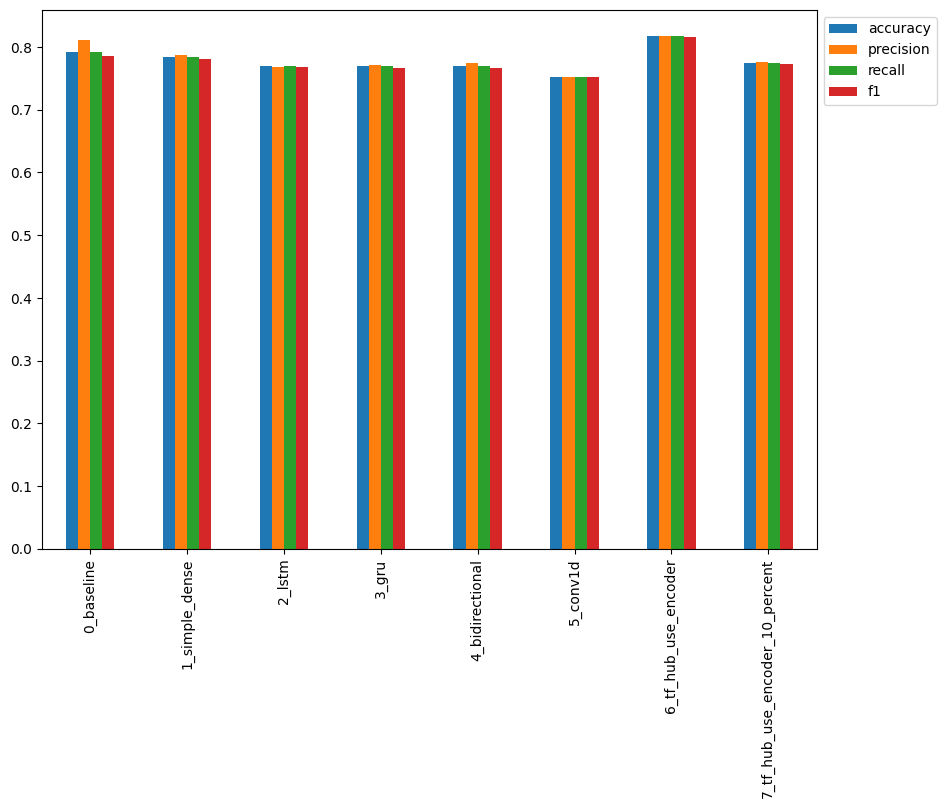

In [102]:
all_model_results.plot.bar(figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<Axes: >

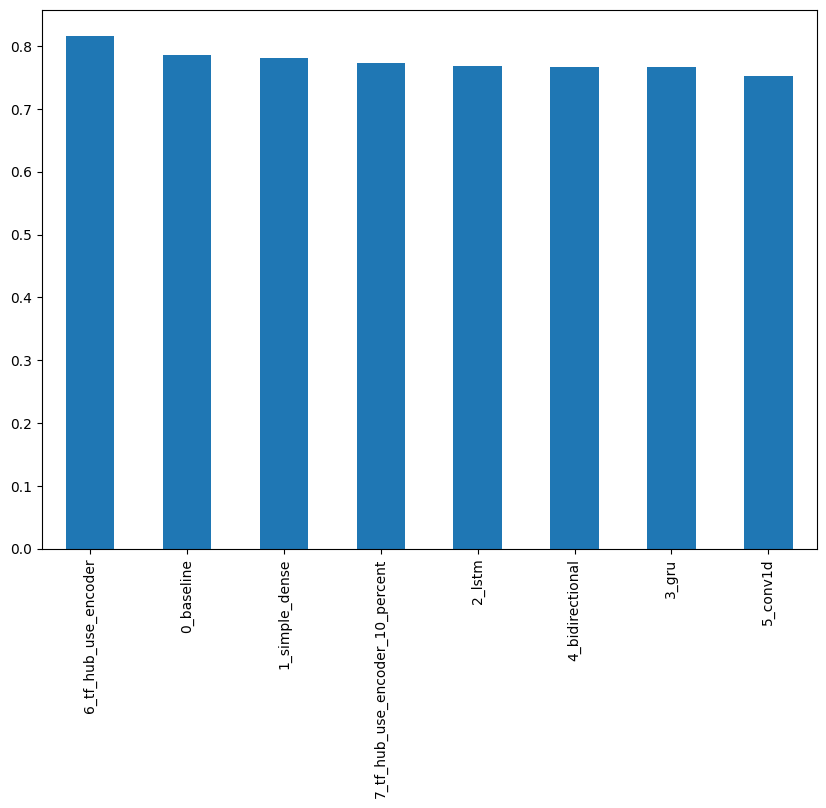

In [103]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot.bar(figsize=(10, 7))